### Get channel statistics

In [2]:
from googleapiclient.discovery import build

from  os import environ

import pandas as pd 
import numpy as np

from dotenv import load_dotenv

import matplotlib.ticker as ticker
import matplotlib.pyplot  as plt
import seaborn as sns

from IPython.display import display, JSON

### Youtube API

In [4]:
chanel_ids = ['UCKQdc0-Targ4nDIAUrlfKiA', 
              'UCJQJAI7IjbLcpsjWdSzYz0Q',
             'UCcJQ96WlEhJ0Ve0SLmU310Q',
             'UCirb0k3PnuQnRjh8tTJHJuA',
             'UCqO40lbcG_j5R3imKDrYijQ']

load_dotenv()
api_key = environ.get("api_key")

api_service_name = "youtube"
api_version = "v3"

# Get credentials and create an API client
youtube = build(
    api_service_name, api_version, developerKey = api_key)

In [5]:
def get_chanel_stats(youtube, chanel_ids):

    all_data  = []
    
    request = youtube.channels().list(
        part="snippet,contentDetails,statistics",
        id=','.join(chanel_ids)
    )
    response = request.execute()
    
    # loop through items
    for item in response['items']:
        data = {'channelName': item['snippet']['title'],
                'subscribers': item['statistics']['subscriberCount'],
                'views': item['statistics']['viewCount'],
                'totalVideos': item['statistics']['videoCount'],
                'playlistId': item['contentDetails']['relatedPlaylists']['uploads']
        }

        all_data.append(data)
    return(pd.DataFrame(all_data))



In [6]:
chanels_stats = get_chanel_stats(youtube, chanel_ids)

In [7]:
chanels_stats

,channelName,subscribers,views,totalVideos,playlistId
0,Python Simplified,161000,5899903,124,UUKQdc0-Targ4nDIAUrlfKiA
1,Thu Vu data analytics,120000,3229822,58,UUJQJAI7IjbLcpsjWdSzYz0Q
2,The PyCoach,19900,1069253,49,UUqO40lbcG_j5R3imKDrYijQ
3,Internet Made Coder,214000,8560622,82,UUcJQ96WlEhJ0Ve0SLmU310Q
4,Kimberly Fessel,14500,710438,54,UUirb0k3PnuQnRjh8tTJHJuA


In [8]:
# Convert count columns to numeric columns
numeric_cols = ['subscribers', 'views', 'totalVideos']

chanels_stats[numeric_cols] = chanels_stats[numeric_cols].astype('int64')

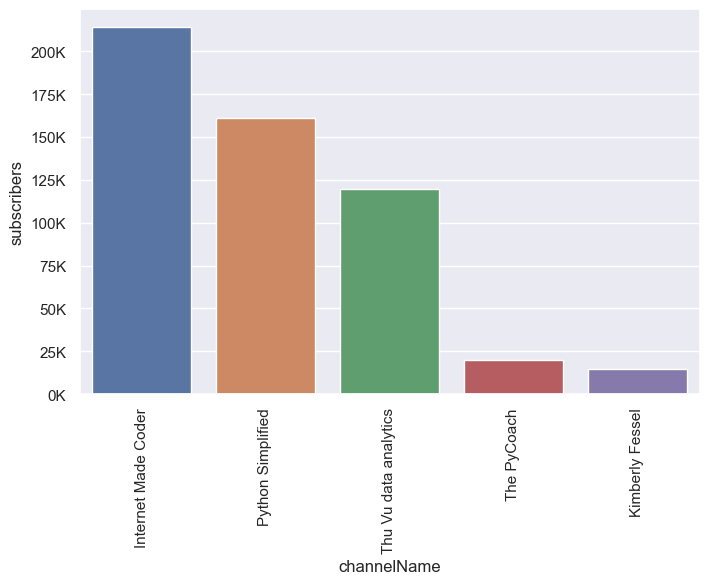

In [14]:
sns.set(rc={'figure.figsize':(8,5)})
ax = sns.barplot(x='channelName', y='subscribers', data=chanels_stats.sort_values('subscribers', ascending=False))
ax.yaxis.set_major_formatter(ticker.FuncFormatter(lambda x, pos: '{:,.0f}'.format(x/1000) + 'K'))
plot = ax.set_xticklabels(ax.get_xticklabels(),rotation = 90)

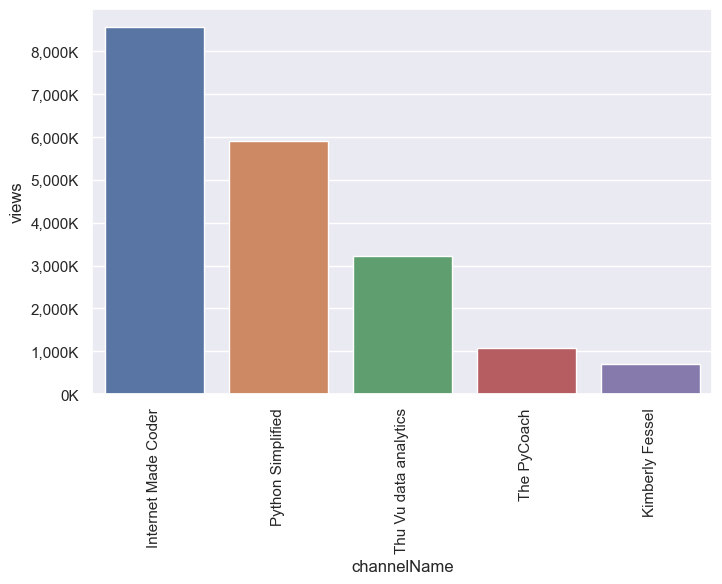

In [15]:
ax = sns.barplot(x='channelName', y='views', data=chanels_stats.sort_values('views', ascending=False))
ax.yaxis.set_major_formatter(ticker.FuncFormatter(lambda x, pos: '{:,.0f}'.format(x/1000) + 'K'))
plot = ax.set_xticklabels(ax.get_xticklabels(),rotation = 90)

In [16]:
def get_video_ids(youtube, playlist_id):
    
    video_ids = []
    
    request = youtube.playlistItems().list(
        part="snippet,contentDetails",
        playlistId=playlist_id,
        maxResults = 50
    )
    response = request.execute()
    
    for item in response['items']:
        video_ids.append(item['contentDetails']['videoId'])
        
    next_page_token = response.get('nextPageToken')
    while next_page_token is not None:
        request = youtube.playlistItems().list(
                    part='contentDetails',
                    playlistId = playlist_id,
                    maxResults = 50,
                    pageToken = next_page_token)
        response = request.execute()

        for item in response['items']:
            video_ids.append(item['contentDetails']['videoId'])

        next_page_token = response.get('nextPageToken')
        
    return video_ids



def get_video_details(youtube, videos_ids):

    all_video_info = []
    
    for i in range(0, len(video_ids), 50):
        request = youtube.videos().list(
            part="snippet,contentDetails,statistics",
            id=','.join(video_ids[i:i+50])
        )
        response = request.execute() 

        for video in response['items']:
            stats_to_keep = {'snippet': ['channelTitle', 'title', 'description', 'tags', 'publishedAt'],
                             'statistics': ['viewCount', 'likeCount', 'favouriteCount', 'commentCount'],
                             'contentDetails': ['duration', 'definition', 'caption']
                            }
            video_info = {}
            video_info['video_id'] = video['id']

            for k in stats_to_keep.keys():
                for v in stats_to_keep[k]:
                    try:
                        video_info[v] = video[k][v]
                    except:
                        video_info[v] = None

            all_video_info.append(video_info)
    
    return pd.DataFrame(all_video_info)


def get_comments_in_videos(youtube, videos_ids):

    all_comments = []
    
    for video_id in videos_ids:
        try:   
            request = youtube.commentThreads().list(
                part="snippet,replies",
                videoId=video_id
            )
            response = request.execute()
        
            comments_in_video = [comment['snippet']['topLevelComment']['snippet']['textOriginal'] for comment in response['items'][0:10]]
            comments_in_video_info = {'video_id': video_id, 'comments': comments_in_video}

            all_comments.append(comments_in_video_info)
            
        except: 
            # When error occurs - most likely because comments are disabled on a video
            print('Could not get comments for video ' + video_id)
        
    return pd.DataFrame(all_comments)

In [21]:
comments_data.head()

,video_id,comments
0,YotbvhndSf4,"[very nice, Very clearly explained, easy to un..."
1,Eg0NJcUWLRM,[Thank you Kimberly. You made my data-viz to n...
2,2wRHBodrWuY,"[how do you match a colour to a hue factor, th..."
3,xSS59Ga64rQ,"[Perfect! Thank you, Thank you so much, I love..."
4,_FO8jUMa65M,[Thanks it helped!\nw.r.t time = 6:43\nJust ad...


### Get video statistics for all the channels

In [18]:
# Create a dataframe with video statistics and comments from all channels

video_df = []
comments_df = []

for c in chanels_stats['channelName'].unique():
    print("Getting video information from channel: " + c)
    playlist_id = chanels_stats.loc[chanels_stats['channelName']== c, 'playlistId'].iloc[0]
    video_ids = get_video_ids(youtube, playlist_id)
    
    # get video data
    video_data = get_video_details(youtube, video_ids)
    # get comment data
    comments_data = get_comments_in_videos(youtube, video_ids)
    
    video_df.append(video_data)
    comments_df.append(comments_data)

    
    # append video data together and comment data toghether
video_df = pd.concat(video_df, ignore_index=True)
comments_df = pd.concat(comments_df, ignore_index=True)

Getting video information from channel: Python Simplified
Getting video information from channel: Thu Vu data analytics
Getting video information from channel: The PyCoach
Getting video information from channel: Internet Made Coder
Getting video information from channel: Kimberly Fessel


In [19]:
video_df.shape, comments_df.shape

((367, 13), (367, 2))

In [22]:
video_df.to_csv('../output/video_youtube.csv',index = False)
comments_df.to_csv('../output/comments_youtube.csv', index = False)